In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas_bokeh
# pandas_bokeh.output_notebook()

import gc
import os
import pickle
import random
import time
from collections import Counter, defaultdict
from functools import partial
from pathlib import Path

# import librosa
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit, KFold
from lightgbm import LGBMClassifier, LGBMRegressor
from category_encoders import *

import warnings
import cmath
warnings.simplefilter(action='ignore', category=FutureWarning)


In [14]:
path = '../data/'
trn = pd.read_csv(path + 'train.csv')
sub = pd.read_csv(path + 'test.csv')
target = trn['total_price']


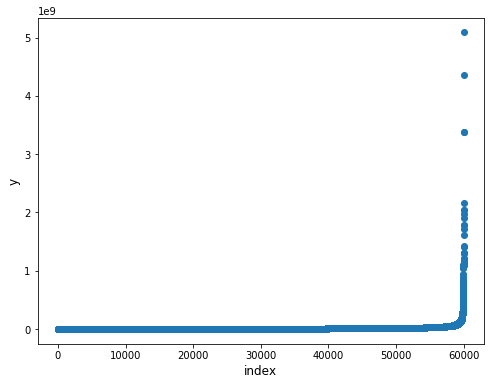

In [16]:
plt.figure(figsize=(8,6))
plt.scatter(range(trn.shape[0]), np.sort(trn.total_price.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.show()

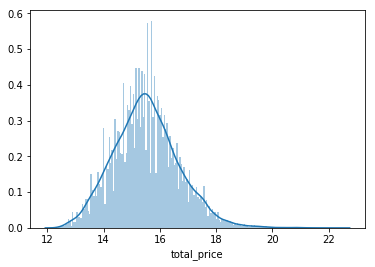

In [3]:
sns.distplot(np.log1p(target), bins =200)

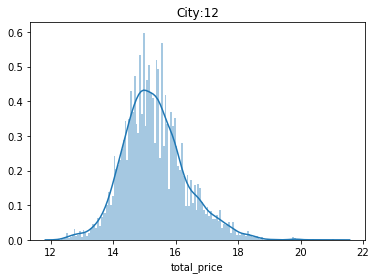

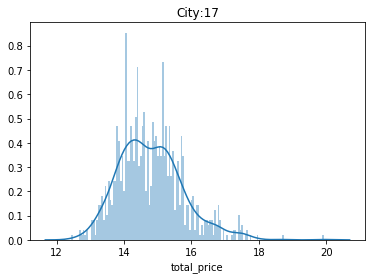

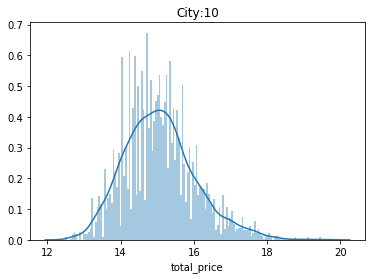

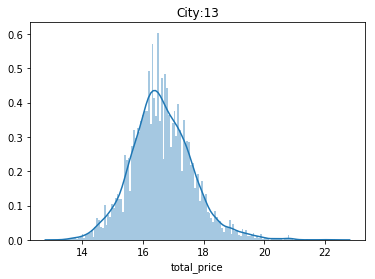

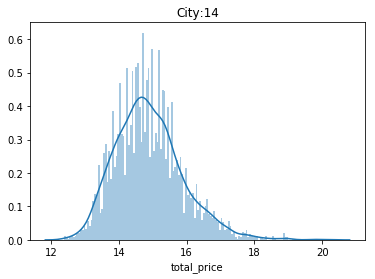

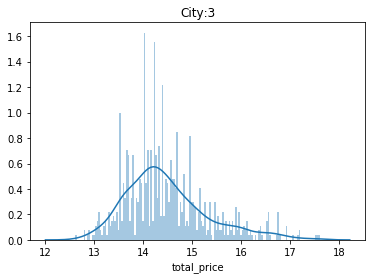

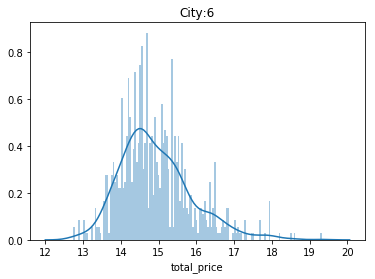

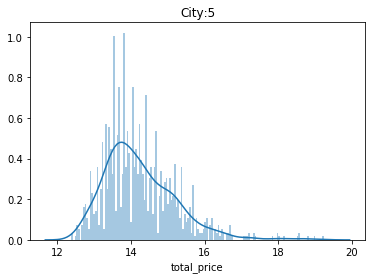

In [13]:
for i in trn.city.unique():
    sns.distplot(np.log1p(trn[trn['city']==i]['total_price']), bins = 150)
    plt.title('City:{}'.format(i))
    plt.show()

>> There is pike (中產階級？)

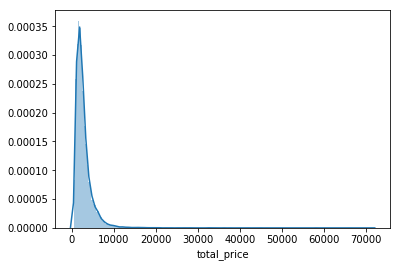

In [6]:
# np.square(trn[target])
sns.distplot(np.sqrt(trn[target]), bins = 200)

In [7]:
trn[target].describe()

count    6.000000e+04
mean     1.293727e+07
std      5.522463e+07
min      2.261495e+05
25%      2.433114e+06
50%      5.240482e+06
75%      1.123932e+07
max      5.088279e+09
Name: total_price, dtype: float64

# Geo
- village_income_median 各里年收入中位數 (482 // 462)
- town_population 各鄉鎮市區人口數 (219 // 183 被裝箱過)
- town_area 各鄉鎮市區面積 (219 // 183 被裝箱過)
- town_population_density 各鄉鎮市區人口密度 (213 // 179)
- doc_Rate 各縣市博士教育程度人口 (11)
- master_rate 各縣市碩士教育程度人口占比 (11)
- bachelor_rate 各縣市大學教育程度人口占比 (11)
- highschool_rate 各縣市高中教育程度人口占比 (11)
- jobschool_rate 各縣市專科學校教育程度人口占比 (11)
- junior_rate 各縣市國中教育程度人口占比 (11)
- elementary_rate 各縣市國小教育程度人口占比 (11)
- born_rate 各縣市出生率 (11)

- 用這些數字(11/213/219/482)去類聚 lon/lat ～ Kmeans K
- lon ~ 231
- lat ~ 190
- lonlat ~ 609

In [9]:
combine = pd.concat([trn, sub])
kmeans = KMeans(n_clusters=11, random_state=2, n_init = 11).fit(combine[['lat','lon']])
combine['label'] = kmeans.labels_

gc.collect()

# plt.figure(figsize = (10,10))
# for label in combine.label.unique():
#     plt.plot(combine.lon[combine.label == label],combine.lat[combine.label == label],'.', 
#              alpha = 0.8, markersize = 0.3)

# plt.title('Clusters of Taiwan Training Set')
# plt.show()


41

In [12]:
kmeans.cluster_centers_[2,0]

-37.9990288838702

In [71]:
plt.figure(figsize = (10,10))
for label in combine.city.unique():
    plt.plot(combine.lon[combine.city == label],combine.lat[combine.city == label],'.', 
             alpha = 0.8, markersize = 0.3)

plt.title('Clusters of Taiwan Training Set')
plt.show()

In [19]:
# trn[['lon', 'lat']].head()
# 東經120度58分25.975秒，
# 北緯23度58分32.34秒

combine['lat'].max(), combine['lat'].min(), combine['lon'].max(), combine['lon'].min()

(-37.46, -40.01, 119.66, 117.01)

## Ratation Matrix

### Pros
- 知道哪裡是炒作區，可以細緻化處理
### Diffuculty
- 不是簡單的線性轉換

In [59]:
def rotate(x, theta):
    print('X shape', x.shape)
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                [np.sin(theta), np.cos(theta)]])

    return pd.DataFrame(np.matmul( x, rotation_matrix)).values

# 東經120度58分25.975秒，
# 北緯23度58分32.34秒

loc_df[['lat','lon']] = rotate(trn[['lat','lon']].values, np.pi/180)

X shape (60000, 2)


/home/kevinco27/.local/lib/python3.5/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


# GEO Statistic
- village_income_median 各里年收入中位數 (482 // 462)
- town_population 各鄉鎮市區人口數 (219 // 183 被裝箱過)
- town_area 各鄉鎮市區面積 (219 // 183 被裝箱過)
- town_population_density 各鄉鎮市區人口密度 (213 // 179)
- doc_Rate 各縣市博士教育程度人口 (11)
- master_rate 各縣市碩士教育程度人口占比 (11)
- bachelor_rate 各縣市大學教育程度人口占比 (11)
- highschool_rate 各縣市高中教育程度人口占比 (11)
- jobschool_rate 各縣市專科學校教育程度人口占比 (11)
- junior_rate 各縣市國中教育程度人口占比 (11)
- elementary_rate 各縣市國小教育程度人口占比 (11)
- born_rate 各縣市出生率 (11)
- death_date 各縣市死亡率
- marriage_rate 各縣市結婚率
- divorce_rate 各縣市離婚率

In [36]:
col = 'marriage_rate'
trn[col].nunique(),sub[col].nunique()

(11, 11)

In [18]:
trn.groupby('label')['total_floor'].mean()

label
0     8.899896
1     7.174251
2     8.275480
3     7.866247
4     5.166905
5     3.740187
6     8.066055
7     8.724574
8     7.829296
9     6.807418
10    3.462176
Name: total_floor, dtype: float64

In [20]:
#### ???????????
trn.groupby('label')['village_income_median'].mean()

label
0     653.356792
1     629.057915
2     652.904071
3     647.800176
4     640.211166
5     586.766373
6     733.201914
7     713.925214
8     673.323604
9     959.348787
10    632.303891
Name: village_income_median, dtype: float64

In [17]:
trn.groupby('label')['doc_Rate'].mean()

label
0     0.003515
1     0.004168
2     0.003948
3     0.006003
4     0.004374
5     0.002574
6     0.007856
7     0.006212
8     0.003454
9     0.005346
10    0.002162
Name: doc_Rate, dtype: float64

## Date EDA
### 找出時間序列的相關因素

- txn_floor 交易樓層
- txn_dt 交易日期
- building_complete_dt 建物完成日期

In [45]:
trn['txn_dt'].min(),trn['txn_dt'].max()

(18112, 20665)

In [46]:
trn['building_complete_dt'].min(), trn['building_complete_dt'].max()

(123, 20577)

In [62]:
trn['dt_gap'] = trn['txn_dt'] - trn['building_complete_dt']
sub['dt_gap'] = sub['txn_dt'] - sub['building_complete_dt']

trn['dt_gap'].min(), trn['dt_gap'].max()

/home/kevinco27/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/kevinco27/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(5, 18287)

In [42]:
trn.groupby(['label','txn_floor'])['total_price'].mean()

label  txn_floor
0      1.0          2.233472e+06
       2.0          7.973286e+05
       3.0          7.666652e+05
       4.0          8.210696e+05
       5.0          3.564613e+06
       6.0          1.013307e+06
       7.0          6.009398e+05
       8.0          7.739353e+05
       9.0          1.130981e+06
       10.0         1.049366e+06
       11.0         8.040831e+05
       12.0         8.105498e+05
       14.0         7.202459e+05
       15.0         8.842566e+05
1      1.0          4.179114e+06
       2.0          3.104472e+06
       3.0          4.081815e+06
       4.0          3.085099e+06
       5.0          3.173141e+06
       6.0          5.634029e+06
       7.0          5.138622e+06
       8.0          5.845238e+06
       9.0          5.795516e+06
       10.0         5.664627e+06
       11.0         6.668057e+06
       12.0         8.587025e+06
       13.0         1.150148e+07
       14.0         1.043231e+07
       15.0         2.063990e+07
       16.0         6.0341

## Distribution Checking

In [34]:
trn.isnull().sum().sort_values(ascending=False).head()/trn.shape[0]

parking_area             0.948283
parking_price            0.767750
txn_floor                0.265033
village_income_median    0.019033
label                    0.000000
dtype: float64

In [35]:
sub.isnull().sum().sort_values(ascending=False).head()/sub.shape[0]

parking_area             0.9500
parking_price            0.7710
txn_floor                0.2639
village_income_median    0.0184
XIV_MIN                  0.0000
dtype: float64

In [28]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')

def distribution_chceck(trn, sub, real_target, folds):
    diff = np.setxor1d(trn.columns, sub.columns)
    print(diff)
    real_target = trn[real_target]
    new_target = 'isTrain'
    
    trn[new_target] = 1
    sub[new_target] = 0
    combine = pd.concat([trn, sub])
    print('combine shape',combine.shape)
    combine.drop(diff, axis=1 ,inplace=True)
    assert combine.shape[1] == sub.shape[1]
    combine.drop('building_id', axis=1 ,inplace=True)
    
    feats = [f for f in combine.columns if f not in [ new_target,'total_price']]
    X = combine[feats]
    y = combine[new_target]
    
    
    sss = StratifiedShuffleSplit(n_splits=folds, test_size=0.2, random_state=0)
    feature_importance_df = pd.DataFrame()
    oof_preds = np.zeros(combine.shape[0])
    
    for fold_, (train_index, test_index) in enumerate(sss.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf = LGBMClassifier()
        clf.fit(X_train, y_train, eval_set=[ (X_test, y_test )], 
                eval_metric = 'auc', verbose= 10, early_stopping_rounds= 10)
        
        y_pred = clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:,1]
        print('Fold {}'.format(fold_ + 1), 'RoC-AUC: {}'.format(roc_auc_score(y_test, y_pred)))
        fold_importance_df = pd.DataFrame()
        print(len(feats), len(clf.feature_importances_))
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
#         fold_importance_df["shap_values"] = abs(shap.TreeExplainer(clf).shap_values(valid_x)[:,:test_df.shape[1]]).mean(axis=0).T
        fold_importance_df["fold"] = fold_+ 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    display_importances(feature_importance_df)

distribution_chceck(trn, sub, 'total_price', folds=5)

[]
combine shape (70000, 237)


/home/kevinco27/.local/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/kevinco27/.local/lib/python3.5/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training until validation scores don't improve for 10 rounds.
[10]	valid_0's auc: 0.504016	valid_0's binary_logloss: 0.410129
Early stopping, best iteration is:
[4]	valid_0's auc: 0.510684	valid_0's binary_logloss: 0.41011
Fold 1 RoC-AUC: 0.5106839583333334
234 234
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's auc: 0.515885	valid_0's binary_logloss: 0.410429
Early stopping, best iteration is:
[4]	valid_0's auc: 0.508065	valid_0's binary_logloss: 0.410191
Fold 2 RoC-AUC: 0.5080651666666667
234 234
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's auc: 0.492167	valid_0's binary_logloss: 0.41065
Early stopping, best iteration is:
[1]	valid_0's auc: 0.489641	valid_0's binary_logloss: 0.410171
Fold 3 RoC-AUC: 0.48964079166666663
234 234
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's auc: 0.497986	valid_0's binary_logloss: 0.410614
Early stopping, best iteration is:
[1]	valid_0's auc: 0.504148	valid_0's b

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


## Train / Test 分佈一致，所以～這是一場，特徵大戰～ Ensemble大戰 ～

## Target Encoding / 會很好用 ～～～ ^_______________^
- groupby lon-lat 

In [1]:
# # use target encoding to encode two categorical features
# enc = TargetEncoder(cols=['city']).fit(trn[['city']], 'building_area')

# # transform the datasets
# training_numeric_dataset = enc.transform(trn[['city']], 'building_area')#.rename(cols={'city':'city_targ'})
# testing_numeric_dataset = enc.transform(sub[['city']])

In [11]:
training_numeric_dataset.rename(columns={'city':'city_targ'}, inplace=True)
testing_numeric_dataset.rename(columns={'city':'city_targ'}, inplace=True)


## Metrics Define

In [12]:
trn = pd.concat([trn, training_numeric_dataset], axis=1)
sub = pd.concat([sub, testing_numeric_dataset], axis=1)
trn.shape, sub.shape

((60000, 236), (10000, 235))

In [ ]:
def hit_rate(y_true, y_pred):
    return np.mean(np.array([1 if i <= 0.1 else 0 for i in np.abs((y_pred - y_true)/y_true)]))

def Mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true)/y_true))

def score(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    return (np.round(hit_rate(y_true, y_pred), 4)*1e4 + 1 - Mape(y_true, y_pred))

def model(trn, sub, folds):
    
    feats = [f for f in trn.columns if f not in ['building_id', 'total_price','is_Train']]
    combine = pd.concat([trn[feats], sub[feats]])
    X = trn[feats]
    y = np.log1p(target)
    
    
    sss = KFold(n_splits=10,shuffle=True, random_state=0)
    feature_importance_df = pd.DataFrame()
    oof_preds = np.zeros(combine.shape[0])
    
    for fold_, (train_index, test_index) in enumerate(sss.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        clf = LGBMRegressor(n_estimators=80000,
                            learning_rate =  0.003,
                            num_leaves=31,                
                            feature_fraction = 0.6,
                            bagging_fraction= 0.7,
                            n_josb=-1)
        
        clf.fit(X_train, y_train, eval_set=[ (X_test, y_test )], 
                eval_metric= 'mae', verbose= 1000, early_stopping_rounds= 300)
        
        y_pred = np.expm1(clf.predict(X_test, num_iteration=clf.best_iteration_))
        print('Fold {}'.format(fold_ + 1), 'Hit-Rate plus MAPE: {}'.format(score(np.expm1(y_test), y_pred)))
        
        fold_importance_df = pd.DataFrame()
        print(len(feats), len(clf.feature_importances_))
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
#         fold_importance_df["shap_values"] = abs(shap.TreeExplainer(clf).shap_values(valid_x)[:,:test_df.shape[1]]).mean(axis=0).T
        fold_importance_df["fold"] = fold_+ 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    display_importances(feature_importance_df)


model(trn, sub, folds=5)

Training until validation scores don't improve for 100 rounds.
[700]	valid_0's l1: 0.298567	valid_0's l2: 0.158707
[1400]	valid_0's l1: 0.208082	valid_0's l2: 0.0812407
[2100]	valid_0's l1: 0.185622	valid_0's l2: 0.0662971
[2800]	valid_0's l1: 0.175375	valid_0's l2: 0.0599528
[3500]	valid_0's l1: 0.168914	valid_0's l2: 0.0561347
[4200]	valid_0's l1: 0.164451	valid_0's l2: 0.0535612
[4900]	valid_0's l1: 0.161279	valid_0's l2: 0.0517741
[5600]	valid_0's l1: 0.158864	valid_0's l2: 0.0503873
[6300]	valid_0's l1: 0.156956	valid_0's l2: 0.0493186
[7000]	valid_0's l1: 0.155298	valid_0's l2: 0.0484042
[7700]	valid_0's l1: 0.153849	valid_0's l2: 0.0476049
[8400]	valid_0's l1: 0.152515	valid_0's l2: 0.0468827
[9100]	valid_0's l1: 0.151341	valid_0's l2: 0.0462718
[9800]	valid_0's l1: 0.150212	valid_0's l2: 0.0456803
[10500]	valid_0's l1: 0.149174	valid_0's l2: 0.0451525
[11200]	valid_0's l1: 0.148247	valid_0's l2: 0.0446644
[11900]	valid_0's l1: 0.147368	valid_0's l2: 0.0442286
[12600]	valid_0's 

In [47]:
sub['label'].value_counts()

5     2437
7     1560
1     1224
2     1217
9      944
0      931
4      805
8      315
3      262
6      162
10     143
Name: label, dtype: int64

## Car Price Analysis

In [52]:
trn[trn['parking_area'].notnull()]['label'].value_counts()
# .shape, trn[trn['parking_price'].notnull()].shape



5     799
7     627
9     528
2     421
0     386
1     144
3     119
4      51
10     18
8       7
6       3
Name: label, dtype: int64

In [64]:
trn['label'].unique()

array([ 1,  5,  8,  2,  7,  6,  9,  0,  4, 10,  3])

In [66]:
for i in trn['label'].unique():
    print(i, trn[trn['label']==i]['total_price'].describe(), '\n')

1 count    7.366000e+03
mean     6.382178e+06
std      3.750206e+07
min      2.470484e+05
25%      1.235694e+06
50%      2.432526e+06
75%      5.000416e+06
max      2.038068e+09
Name: total_price, dtype: float64 

5 count    1.516000e+04
mean     2.003022e+07
std      8.717871e+07
min      4.928976e+05
25%      5.152761e+06
50%      8.510296e+06
75%      1.775064e+07
max      5.088279e+09
Name: total_price, dtype: float64 

8 count    1.637000e+03
mean     3.404896e+06
std      1.199734e+07
min      2.299748e+05
25%      7.621374e+05
50%      1.314591e+06
75%      2.776181e+06
max      2.246702e+08
Name: total_price, dtype: float64 

2 count    7.196000e+03
mean     8.745190e+06
std      2.596725e+07
min      2.261495e+05
25%      2.299707e+06
50%      4.141155e+06
75%      7.996460e+06
max      1.423615e+09
Name: total_price, dtype: float64 

7 count    9.228000e+03
mean     1.474758e+07
std      5.621213e+07
min      3.531843e+05
25%      4.060377e+06
50%      6.807736e+06
75%      1

In [7]:
! pip3 install category_encoders --user

Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 7, in <module>
    from pip import main
ImportError: cannot import name 'main'
